In [1]:
import numpy as np
from os import path
import warnings
import xarray as xarray
import xesmf

# ignore pandas FutureWarnings raised multiple times by xarray
warnings.simplefilter(action='ignore', category=FutureWarning)


def rotate_uv(u, v, angle, in_degrees=False):
    """Rotate velocities from earth-relative to model-relative.
    Args:
        u: west-east component of velocity.
        v: south-north component of velocity.
        angle: angle of rotation from true north to model north.
        in_degrees (bool): typically angle is in radians, but set this to True if it is in degrees.
    Returns:
        Model-relative west-east and south-north components of velocity.
    """
    if in_degrees:
        angle = np.radians(angle)
    urot = np.cos(angle) * u + np.sin(angle) * v
    vrot = -np.sin(angle) * u + np.cos(angle) * v
    return urot, vrot


def fill_missing(arr, xdim='locations', zdim='z'):
    """Fill missing data along the boundaries.
    Extrapolates horizontally first, then vertically. 
   
    Args:
        arr: xarray DataArray or Dataset to be fillled.
        xdim: horizontal dimension of the dataset. 
        zdim: vertical dimension of the dataset.
    
    Returns:
        Filled DataArray or Dataset.
    """
    filled = arr.ffill(dim=xdim, limit=None)
    if zdim is not None:
        filled = filled.ffill(dim=zdim, limit=None).fillna(0)
    return filled


def flood_missing(arr, **kwargs):
    """Flood missing data (over land) using HCtFlood. 
    Had some trouble installing HCtFlood on analysis, so it is 
    imported by adding it to the path. 
    Import is done inside this function so that 
    everything else still works if HCtFlood is unavailable.
    Args:
        arr (xarray.DataArray): Array to be flooded.
        **kwargs: Additional keyword arguments passed to flooding function.
    Returns:
        xarray.DataArray: Flooded array.
    """
    # https://github.com/raphaeldussin/HCtFlood
    import sys
    sys.path.append('/home/Andrew.C.Ross/git/HCtFlood')
    from HCtFlood import kara as hct
    flooded = hct.flood_kara(arr, **kwargs)

    # Check for 2D or 3D case. 
    # Assume that 3D case is a function of time and space, not depth and space,
    # unless zdim was included in keyword arguments. 
    # Harder to assume that if zdim was not passed but the flooded 
    # data has a z dimension longer than 1, so warn.
    # If it is a function of time and space, drop the 
    # depth dimension added by flood_kara.
    if arr.ndim <= 3 and 'zdim' not in kwargs:
        if 'z' in arr.dims and len(arr.z) > 1:
            warnings.warn('flood_kara used the default name for the z dimension. Not dropping z dimension.')
        else:
            # flood_kara adds an undesired z=0, so drop it for 2D vars
            flooded = flooded.isel(z=0).drop('z')

    return flooded


def find_datavar(ds):
    """
    Given an xarray Dataset containing one data variable of interest
    and possibly extra variables for lat and lon,
    return just the name of the variable of interest.
    Args:
        ds (xarray.Dataset): Dataset potentially containing variables 'lat' and 'lon',
            plus one and only one other variable of interest.
    Raises:
        Exception: if there are multiple potential variables of interest 
            (more than one variable not named lat or lon).
    Returns:
        xarray.DataArray: DataArray of variable of interest from Dataset. 
    """
    names = [x for x in ds if x not in ['lon', 'lat']]
    if len(names) > 1:
        raise Exception('Found multiple potential data variables')
    return names[0]


def ap2ep(uc, vc):
    """Convert complex tidal u and v to tidal ellipse.
    Adapted from ap2ep.m for matlab
    Original copyright notice:
    %Authorship Copyright:
    %
    %    The author retains the copyright of this program, while  you are welcome
    % to use and distribute it as long as you credit the author properly and respect
    % the program name itself. Particularly, you are expected to retain the original
    % author's name in this original version or any of its modified version that
    % you might make. You are also expected not to essentially change the name of
    % the programs except for adding possible extension for your own version you
    % might create, e.g. ap2ep_xx is acceptable.  Any suggestions are welcome and
    % enjoy my program(s)!
    %
    %
    %Author Info:
    %_______________________________________________________________________
    %  Zhigang Xu, Ph.D.
    %  (pronounced as Tsi Gahng Hsu)
    %  Research Scientist
    %  Coastal Circulation
    %  Bedford Institute of Oceanography
    %  1 Challenge Dr.
    %  P.O. Box 1006                    Phone  (902) 426-2307 (o)
    %  Dartmouth, Nova Scotia           Fax    (902) 426-7827
    %  CANADA B2Y 4A2                   email xuz@dfo-mpo.gc.ca
    %_______________________________________________________________________
    %
    % Release Date: Nov. 2000, Revised on May. 2002 to adopt Foreman's northern semi
    % major axis convention.
    Args:
        uc: complex tidal u velocity
        vc: complex tidal v velocity
    Returns:
        (semi-major axis, eccentricity, inclination [radians], phase [radians])
    """
    wp = (uc + 1j * vc) / 2.0
    wm = np.conj(uc - 1j * vc) / 2.0

    Wp = np.abs(wp)
    Wm = np.abs(wm)
    THETAp = np.angle(wp)
    THETAm = np.angle(wm)

    SEMA = Wp + Wm
    SEMI = Wp - Wm
    ECC = SEMI / SEMA
    PHA = (THETAm - THETAp) / 2.0
    INC = (THETAm + THETAp) / 2.0

    return SEMA, ECC, INC, PHA


def ep2ap(SEMA, ECC, INC, PHA):
    """Convert tidal ellipse to real u and v amplitude and phase.
    Adapted from ep2ap.m for matlab.
    Original copyright notice:
    %Authorship Copyright:
    %
    %    The author of this program retains the copyright of this program, while
    % you are welcome to use and distribute this program as long as you credit
    % the author properly and respect the program name itself. Particularly,
    % you are expected to retain the original author's name in this original
    % version of the program or any of its modified version that you might make.
    % You are also expected not to essentially change the name of the programs
    % except for adding possible extension for your own version you might create,
    % e.g. app2ep_xx is acceptable.  Any suggestions are welcome and enjoy my
    % program(s)!
    %
    %
    %Author Info:
    %_______________________________________________________________________
    %  Zhigang Xu, Ph.D.
    %  (pronounced as Tsi Gahng Hsu)
    %  Research Scientist
    %  Coastal Circulation
    %  Bedford Institute of Oceanography
    %  1 Challenge Dr.
    %  P.O. Box 1006                    Phone  (902) 426-2307 (o)
    %  Dartmouth, Nova Scotia           Fax    (902) 426-7827
    %  CANADA B2Y 4A2                   email xuz@dfo-mpo.gc.ca
    %_______________________________________________________________________
    %
    %Release Date: Nov. 2000
    Args:
        SEMA: semi-major axis
        ECC: eccentricity
        INC: inclination [radians]
        PHA: phase [radians]
    Returns:
        (u amplitude, u phase [radians], v amplitude, v phase [radians])
    """
    Wp = (1 + ECC) / 2. * SEMA
    Wm = (1 - ECC) / 2. * SEMA
    THETAp = INC - PHA
    THETAm = INC + PHA

    wp = Wp * np.exp(1j * THETAp)
    wm = Wm * np.exp(1j * THETAm)

    cu = wp + np.conj(wm)
    cv = -1j * (wp - np.conj(wm))

    ua = np.abs(cu)
    va = np.abs(cv)
    up = -np.angle(cu)
    vp = -np.angle(cv)

    return ua, va, up, vp


def z_to_dz(ds, max_depth=6500.):
    """Given depths of layer centers, get layer thicknesses.
    This works for output after regridding to a model boundary using xesmf.
    Derived from https://github.com/ESMG/regionalMOM6_notebooks/blob/master/creating_obc_input_files/panArctic_OBC_from_global_MOM6.ipynb
    Args:
        ds: xarray.DataArray or xarray.Dataset containing variables 'time', 'z', and 'locations'.
        max_depth: Depth of model bottom. Thickness of bottom layer will be stretched to reach this depth. 
    Returns: 
        xarray.DataArray: 3D <time, z, locations> array of thicknesses. 
    """
    zi = 0.5 * (np.roll(ds['z'], shift=-1) + ds['z'])
    zi[-1] = max_depth
    dz = zi - np.roll(zi, shift=1)
    dz[0] = zi[0]
    nt = ds.time.shape[0]
    nx = ds.lon.shape[0]
    dz = np.tile(dz.data[np.newaxis, :, np.newaxis], (nt, 1, nx))
    da_dz = xarray.DataArray(
        dz,
        coords=[
            ('time', ds['time']),
            ('z', ds['z']),
            ('locations', ds.locations)]
    )
    # attributes seem to not copy over when creating the new array
    for v in ['time', 'z', 'locations']:
        da_dz[v].attrs = ds[v].attrs
    return da_dz


class Segment():
    """One segment of a MOM6 open boundary.
    Note that MOM6 supports segments of any length,
    but here it is assumed that the segment spans an 
    entire north, south, east, or west border. 
    Attributes:
        num (int): segment identification number following MOM6 order (1-4).
        border (str): which border of the model grid the segment represents (north, south, east, or west).
        hgrid: (xarray.Dataset) dataset from opening ocean_hgrid.nc. Contains 'x', 'y', and 'angle_dx' [radians].
        segstr (str): string identifying the segment, used in variable and file names.
        output_dir (str): location to write data for the segment, and location to store xesmf weight files.
        regrid_dir (str): location to save xesmf Regridders. Defaults to output_dir. 
        coords (xarray.Dataset): segment coordinates derived from hgrid (lon, lat, angle relative to true north).
        nx (int): Number of data points in the x direction.
        ny (int): Number of data points in the y direction.
    """

    def __init__(self, num, border, hgrid, output_dir='.', regrid_dir=None):
        self.num = num
        self.border = border
        self.hgrid = hgrid
        self.segstr = f'segment_{self.num:03d}'
        self.output_dir = output_dir

        if regrid_dir is None:
            self.regrid_dir = self.output_dir
        else:
            self.regrid_dir = regrid_dir

    @property
    def coords(self):
        if self.border == 'south':
            return xarray.Dataset({
                'lon': self.hgrid['x'].isel(nyp=0),
                'lat': self.hgrid['y'].isel(nyp=0),
                'angle': self.hgrid['angle_dx'].isel(nyp=0)
            })
        elif self.border == 'north':
            return xarray.Dataset({
                'lon': self.hgrid['x'].isel(nyp=-1),
                'lat': self.hgrid['y'].isel(nyp=-1),
                'angle': self.hgrid['angle_dx'].isel(nyp=-1)
            })
        elif self.border == 'west':
            return xarray.Dataset({
                'lon': self.hgrid['x'].isel(nxp=0),
                'lat': self.hgrid['y'].isel(nxp=0),
                'angle': self.hgrid['angle_dx'].isel(nxp=0)
            })
        elif self.border == 'east':
            return xarray.Dataset({
                'lon': self.hgrid['x'].isel(nxp=-1),
                'lat': self.hgrid['y'].isel(nxp=-1),
                'angle': self.hgrid['angle_dx'].isel(nxp=-1)
            })

    @property
    def nx(self):
        """Number of data points in the x-direction"""
        if self.border in ['south', 'north']:
            return len(self.coords['lon'])
        elif self.border in ['west', 'east']:
            return 1
    
    @property
    def ny(self):
        """Number of data points in the y-direction"""
        if self.border in ['south', 'north']:
            return 1
        elif self.border in ['west', 'east']:
            return len(self.coords['lat'])
    
    def to_netcdf(self, ds, varnames, suffix=None):
        """Write data for the segment to file.
        Args:
            ds (xarray.Dataset): Segment dataset.
            varnames (str): Name to give the file (e.g. 'temp', 'salt'). 
            suffix (str, optional): Optional suffix to append to the filename (before .nc). Defaults to None.
        """
        for v in ds:
            ds[v].encoding['_FillValue']= 1.0e20
        fname = f'{varnames}_{self.num:03d}_{suffix}.nc' if suffix is not None else f'{varnames}_{self.num:03d}.nc'
        # Set format and attributes for coordinates, including time if it does not already have calendar attribute
        # (may change this to detect whether time is a time type or a float).
        # Need to include the fillvalue or it will be back to nan
        encoding = {
            'time': dict(_FillValue=1.0e20),
            f'lon_{self.segstr}': dict(dtype='float64', _FillValue=1.0e20),
            f'lat_{self.segstr}': dict(dtype='float64', _FillValue=1.0e20)
        }
        if 'calendar' not in ds['time'].attrs:
            encoding.update({'time': dict(dtype='float64', calendar='gregorian', _FillValue=1.0e20)})
        ds.to_netcdf(
            path.join(self.output_dir, fname),
            format='NETCDF3_64BIT',
            engine='netcdf4',
            encoding=encoding,
            unlimited_dims='time'
        )

    def expand_dims(self, ds):
        """Add a length-1 dimension to the variables in a boundary dataset or array.
        Named 'ny_segment_{self.segstr}' if the border runs west to east (a south or north boundary),
        or 'nx_segment_{self.segstr}' if the border runs north to south (an east or west boundary).
        Args:
            ds: boundary array with dimensions <time, (z or constituent), y, x>
        Returns:
            modified array with new length-1 dimension.
        """
        # having z or constituent as second dimension is optional, so offset determines where to place
        # added dim
        if 'z' in ds.coords or 'constituent' in ds.dims:
            offset = 0
        else:
            offset = 1
        if self.border in ['south', 'north']:
            return ds.expand_dims(f'ny_{self.segstr}', 2-offset)
        elif self.border in ['west', 'east']:
            return ds.expand_dims(f'nx_{self.segstr}', 3-offset)

    def rename_dims(self, ds):
        """Rename dimensions to be unique to the segment.
        Args:
            ds (xarray.Dataset): Dataset that might contain 'lon', 'lat', 'z', and/or 'locations'.
        Returns:
            xarray.Dataset: Dataset with dimensions renamed to include the segment identifier and to 
                match MOM6 expectations.
        """
        ds = ds.rename({
            'lon': f'lon_{self.segstr}',
            'lat': f'lat_{self.segstr}'
        })
        if 'z' in ds.coords:
            ds = ds.rename({
                'z': f'nz_{self.segstr}'
            })
        if self.border in ['south', 'north']:
            return ds.rename({'locations': f'nx_{self.segstr}'})
        elif self.border in ['west', 'east']:
            return ds.rename({'locations': f'ny_{self.segstr}'})
        
    def zeros(self, time, nz=0):
        """Create an appropriately shaped DataArray of zeros.
        Useful for things where the boundary is set to a constant.
        Args:
            time: Time coordinate to give the array.
            nz (int, optional): Length of the vertical dimension to give the array, if greater than 0. Defaults to 0.
        Returns:
            xarray.DataArray: Array of zeros. 
        """
        nt = len(time)
        if nz > 0:
            return xarray.DataArray(
                np.zeros((nt, nz, self.ny, self.nx)),
                coords=[time, np.arange(nz), np.arange(self.ny), np.arange(self.nx)],
                dims=['time', f'nz_{self.segstr}', f'ny_{self.segstr}', f'nx_{self.segstr}']
            )
        else:
            return xarray.DataArray(
                np.zeros((nt, self.ny, self.nx)),
                coords=[time, np.arange(self.ny), np.arange(self.nx)],
                dims=['time', f'ny_{self.segstr}', f'nx_{self.segstr}']
            )
    
    def add_coords(self, ds):
        """Add segment lat and lon coordinates to a dataset."""
        if self.border in ['south', 'north']:
            ds[f'lon_{self.segstr}'] = ((f'nx_{self.segstr}', ), self.coords['lon'])
            ds[f'lat_{self.segstr}'] = ((f'nx_{self.segstr}', ), self.coords['lat'])
        elif self.border in ['west', 'east']:
            ds[f'lon_{self.segstr}'] = ((f'ny_{self.segstr}', ), self.coords['lon'])
            ds[f'lat_{self.segstr}'] = ((f'ny_{self.segstr}', ), self.coords['lat'])
        return ds
    
    def regrid_velocity(
                self, usource, vsource, 
                method='nearest_s2d', periodic=False, write=True, 
                flood=False, xdim='lon', ydim='lat', zdim='z', rotate=True, **kwargs):
        """Interpolate velocity onto segment and (optionally) write to file.
        Args:
            usource (xarray.DataArray): Earth-relative u velocity on source grid.
            vsource (xarray.DataArray): Earth-relative v velocity on source grid.
            method (str, optional): Method recognized by xesmf to use to regrid. Defaults to 'nearest_s2d'.
            periodic (bool, optional): Whether the source grid is periodic (passed to xesmf). Defaults to False.
            write (bool, optional): After regridding, write the results to file. Defaults to True.
            flood (bool, optional): As the first step of regridding, horizontally flood the source data. Defaults to False.
            xdim (str, optional): Name of the horizontal x dimension, needed if flooding. Defaults to 'lon'.
            ydim (str, optional): Name of the horizontal y dimension, needed if flooding. Defaults to 'lat'.
            zdim (str, optional): Name of the vertical dimension, needed if flooding. Defaults to 'z'.
        Returns:
            xarray.Dataset: Dataset of regridded boundary data.
        """
        if flood:
            usource = flood_missing(usource, xdim=xdim, ydim=ydim, zdim=zdim)
            vsource = flood_missing(vsource, xdim=xdim, ydim=ydim, zdim=zdim)

        # Horizontally interpolate velocity to MOM boundary.
        uregrid = xesmf.Regridder(
            usource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(self.regrid_dir, f'regrid_{self.segstr}_u.nc'),
            reuse_weights=False
        )
        vregrid = xesmf.Regridder(
            vsource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(self.regrid_dir, f'regrid_{self.segstr}_v.nc'),
            reuse_weights=False
        )
        udest = uregrid(usource)
        vdest = vregrid(vsource)

        # if lat and lon are variables in u/vsource, u/vdest will be dataset
        if isinstance(udest, xarray.Dataset):
            udest = udest.to_array().squeeze()
        if isinstance(vdest, xarray.Dataset):
            vdest = vdest.to_array().squeeze()

        # Rotate velocities to be model-relative.
        if rotate:
            if self.border in ['south', 'north']:
                angle = self.coords['angle']#.rename({'nxp': 'locations'})
            elif self.border in ['west', 'east']:
                angle = self.coords['angle']#.rename({'nyp': 'locations'})
            udest, vdest = rotate_uv(udest, vdest, angle)

        ds_uv = xarray.Dataset({
            f'u_{self.segstr}': udest,
            f'v_{self.segstr}': vdest
        })
        
        if self.border in ['south', 'north']:
            ds_uv = ds_uv.rename_dims({'nxp': 'locations'})
        elif self.border in ['west', 'east']:
            ds_uv = ds_uv.rename_dims({'nyp': 'locations'})
        ds_uv = fill_missing(ds_uv)
        
        # Need to transpose so that time is first,
        # so that it can be the unlimited dimension
        if self.border in ['south', 'north']:
            ds_uv = ds_uv.transpose('time', 'z', 'locations')
        elif self.border in ['west', 'east']:
            ds_uv = ds_uv.transpose('time', 'z', 'locations')
        # Add thickness
        dz = z_to_dz(ds_uv)
        ds_uv[f'dz_u_{self.segstr}'] = dz
        ds_uv[f'dz_v_{self.segstr}'] = dz

        ds_uv['z'] = np.arange(len(ds_uv['z']))

        ds_uv = self.expand_dims(ds_uv)
        ds_uv = self.rename_dims(ds_uv)
        if write:
            self.to_netcdf(ds_uv, 'uv', **kwargs)
        
        return ds_uv

    def regrid_tracer(
            self, tsource, 
            method='nearest_s2d', periodic=False, write=True, 
            flood=False, xdim='lon', ydim='lat', zdim='z',
            regrid_suffix='t', source_var=None, **kwargs):
        """Regrid a tracer onto segment and (optionally) write to file.
        Args:
            tsource (xarray.DataArray): Tracer data on source grid.
            method (str, optional): Method recognized by xesmf to use to regrid. Defaults to 'nearest_s2d'.
            periodic (bool, optional): Whether the source grid is periodic (passed to xesmf). Defaults to False.
            write (bool, optional): After regridding, write the results to file. Defaults to True.
            flood (bool, optional): As the first step of regridding, horizontally flood the source data. Defaults to False.
            xdim (str, optional): Name of the horizontal x dimension, needed if flooding. Defaults to 'lon'.
            ydim (str, optional): Name of the horizontal y dimension, needed if flooding. Defaults to 'lat'.
            zdim (str, optional): Name of the vertical dimension, needed if flooding. Defaults to 'z'.
            regrid_suffix (str, optional): Suffix to add to xesmf weight file name. Useful when regridding multiple tracers from different datasets. 
                Defaults to 't'.
            source_var (str, optional): If tsource is a dataset, this is the variable to regrid.
            **kwargs: additional keyword arguments passed to Segment.to_netcdf().
        Returns:
            xarray.Dataset: Dataset of regridded boundary data.
        """
        if source_var is not None:
            name =  source_var
        else:
            name = tsource.name
        
        if flood:
            tsource = flood_missing(tsource, xdim=xdim, ydim=ydim, zdim=zdim)

        regrid = xesmf.Regridder(
            tsource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(self.regrid_dir, f'regrid_{self.segstr}_{regrid_suffix}.nc'),
            reuse_weights=False
        )
        tdest = regrid(tsource)
        


        if not isinstance(tdest, xarray.Dataset):
            tdest = tdest.to_dataset()
            
        if 'z' in tsource.coords:
            tdest = fill_missing(tdest)
            # Need to transpose so that time is first,
            # so that it can be the unlimited dimension
            if self.border in ['south', 'north']:
                tdest=tdest.rename({'nxp': 'locations'})
                tdest = tdest.transpose('time', 'z', 'locations')
            elif self.border in ['west', 'east']:
                tdest=tdest.rename({'nyp': 'locations'})
                tdest = tdest.transpose('time', 'z', 'locations')
            dz = z_to_dz(tdest)
            tdest[f'dz_{name}_{self.segstr}'] = dz
            tdest['z'] = np.arange(len(tdest['z']))
        else:
            tdest = fill_missing(tdest, zdim=None)
            # Need to transpose so that time is first,
            # so that it can be the unlimited dimension
            if self.border in ['south', 'north']:
                tdest=tdest.rename({'nxp': 'locations'})
                tdest = tdest.transpose('time', 'locations')
            elif self.border in ['west', 'east']:
                tdest=tdest.rename({'nyp': 'locations'})
                tdest = tdest.transpose('time', 'locations')
        
        tdest = self.expand_dims(tdest)
        tdest = self.rename_dims(tdest)
        tdest = tdest.rename({name: f'{name}_{self.segstr}'})
        
        print(type(tdest))
        if write:
            self.to_netcdf(tdest, name, **kwargs)
        
        return tdest

    def regrid_tidal_elevation(
                self, resource, imsource, time, 
                method='nearest_s2d', periodic=False, write=True, 
                flood=False, xdim='nx', ydim='ny', **kwargs):
        """Regrid tidal elevation onto segment and (optionally) write to file.
        It is assumed that real (resource) and imaginary (imsource) components of the 
        constituents have the same coordinates.
        Args:
            resource (xarray.DataArray): Real component of tidal elevation on source grid.
            imsource (xarray.DataArray): Imaginary component of tidal elevation on source grid.
            time: Time to add to dataset. Pass a length-1 array to keep it constant in time.
            method (str, optional): Method recognized by xesmf to use to regrid. Defaults to 'nearest_s2d'.
            periodic (bool, optional): Whether the source grid is periodic (passed to xesmf). Defaults to False.
            write (bool, optional): After regridding, write the results to file. Defaults to True.
            flood (bool, optional): As the first step of regridding, horizontally flood the source data. Defaults to False.
            xdim (str, optional): Name of the horizontal x dimension, needed if flooding. Defaults to 'nx'.
            ydim (str, optional): Name of the horizontal y dimension, needed if flooding. Defaults to 'ny'.
            **kwargs: additional keyword arguments passed to Segment.to_netcdf().
        Returns:
            xarray.Dataset: Dataset of regridded boundary data.
        """
        if flood:
            rename = find_datavar(resource)
            imname = find_datavar(imsource)
            # Don't want to do this lazily, but there is a weird dimension mismatch error 
            # when using .compute() or .load(), so use .values.
            # Also, use "constituent" as the time dimension.
            resource[rename] = (resource[rename].dims, flood_missing(resource[rename], xdim=xdim, ydim=ydim, tdim='constituent').values)
            imsource[imname] = (imsource[imname].dims, flood_missing(imsource[imname], xdim=xdim, ydim=ydim, tdim='constituent').values)

        # Horizontally interpolate elevation components
        regrid = xesmf.Regridder(
            resource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(self.regrid_dir, f'regrid_{self.segstr}_tidal_elev.nc'),
            reuse_weights=True
        )
        redest = regrid(resource)
        imdest = regrid(imsource)

        # Fill missing data.
        # Need to do this first because complex would get converted to real
        redest = fill_missing(redest, zdim=None)['hRe']
        imdest = fill_missing(imdest, zdim=None)['hIm']

        # Convert complex
        cplex = redest + 1j * imdest

        # Convert to real amplitude and phase.
        ds_ap = xarray.Dataset({
            f'zamp_{self.segstr}': np.abs(cplex)
        })
        # np.angle doesn't return dataarray
        ds_ap[f'zphase_{self.segstr}'] =  (('constituent', 'locations'), -1 * np.angle(cplex))  # radians

        # Add time coordinate and transpose so that time is first,
        # so that it can be the unlimited dimension
        ds_ap, _ = xarray.broadcast(ds_ap, time)
        ds_ap = ds_ap.transpose('time', 'constituent', 'locations')

        ds_ap = self.expand_dims(ds_ap)
        ds_ap = self.rename_dims(ds_ap)

        if write:
            self.to_netcdf(ds_ap, 'tz', **kwargs)
            
        return ds_ap

    def regrid_tidal_velocity(
            self, uresource, uimsource, vresource, vimsource, time, 
            method='nearest_s2d', periodic=False, write=True, 
            flood=False, xdim='nx', ydim='ny', **kwargs):
        """Regrid tidal velocity onto segment and (optionally) write to file.
        It is assumed that real and imaginary components of the 
        individual u or v velocities have the same coordinates, 
        but the u and v components may have separate coordinates
        [although currently they must have the same names if flooding].
        Args:
            uresource (xarray.DataArray): Real component of tidal u velocity on source grid.
            uimsource (xarray.DataArray): Imaginary component of tidal u velocity on source grid.
            vresource (xarray.DataArray): Real component of tidal v velocity on source grid.
            vimsource (xarray.DataArray): Imaginary component of tidal v velocity on source grid.
            time: Time to add to dataset. Pass a length-1 array to keep it constant in time.
            method (str, optional): Method recognized by xesmf to use to regrid. Defaults to 'nearest_s2d'.
            periodic (bool, optional): Whether the source grid is periodic (passed to xesmf). Defaults to False.
            write (bool, optional): After regridding, write the results to file. Defaults to True.
            flood (bool, optional): As the first step of regridding, horizontally flood the source data. Defaults to False.
            xdim (str, optional): Name of the horizontal x dimension, needed if flooding. Defaults to 'nx'.
            ydim (str, optional): Name of the horizontal y dimension, needed if flooding. Defaults to 'ny'.
            **kwargs: additional keyword arguments passed to Segment.to_netcdf().
        Returns:
            xarray.Dataset: Dataset of regridded boundary data.
        """
        if flood:
            urename = find_datavar(uresource)
            uimname = find_datavar(uimsource)
            vrename = find_datavar(vresource)
            vimname = find_datavar(vimsource)
            # Don't want to do this lazily, but there is a weird dimension mismatch error 
            # when using .compute() or .load(), so use .values.
            # Use "constituent" as the time dimension.
            uresource[urename] = (uresource[urename].dims, flood_missing(uresource[urename], xdim=xdim, ydim=ydim, tdim='constituent').values)
            uimsource[uimname] = (uimsource[uimname].dims, flood_missing(uimsource[uimname], xdim=xdim, ydim=ydim, tdim='constituent').values)
            uresource[vrename] = (vresource[vrename].dims, flood_missing(vresource[vrename], xdim=xdim, ydim=ydim, tdim='constituent').values)
            uimsource[vimname] = (vimsource[vimname].dims, flood_missing(vimsource[vimname], xdim=xdim, ydim=ydim, tdim='constituent').values)

        regrid_u = xesmf.Regridder(
            uresource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(self.regrid_dir, f'regrid_{self.segstr}_tidal_u.nc'),
            reuse_weights=True
        )

        regrid_v = xesmf.Regridder(
            vresource,
            self.coords,
            method=method,
            locstream_out=True,
            periodic=periodic,
            filename=path.join(
                self.regrid_dir, f'regrid_{self.segstr}_tidal_v.nc'),
            reuse_weights=True
        )

        # Interpolate each real and imaginary parts to segment.
        uredest = regrid_u(uresource)['uRe']
        uimdest = regrid_u(uimsource)['uIm']
        vredest = regrid_v(vresource)['vRe']
        vimdest = regrid_v(vimsource)['vIm']

        # Fill missing data.
        # Need to do this first because complex would get converted to real
        uredest = fill_missing(uredest, zdim=None)
        uimdest = fill_missing(uimdest, zdim=None)
        vredest = fill_missing(vredest, zdim=None)
        vimdest = fill_missing(vimdest, zdim=None)

        # Convert to complex, remaining separate for u and v.
        ucplex = uredest + 1j * uimdest
        vcplex = vredest + 1j * vimdest

        # Convert complex u and v to ellipse,
        # rotate ellipse from earth-relative to model-relative,
        # and convert ellipse back to amplitude and phase.
        # There is probably a complicated trig identity for this? But
        # this works too. 
        if self.border in ['south', 'north']:
            angle = self.coords['angle'].rename({'nxp': 'locations'})
        elif self.border in ['west', 'east']:
            angle = self.coords['angle'].rename({'nyp': 'locations'})
        SEMA, ECC, INC, PHA = ap2ep(ucplex, vcplex)
        # INC is np array but angle is xarray
        INC -= angle.data[np.newaxis, :]
        ua, va, up, vp = ep2ap(SEMA, ECC, INC, PHA)

        ds_ap = xarray.Dataset({
            f'uamp_{self.segstr}': ua,
            f'vamp_{self.segstr}': va
        })
        # up, vp aren't dataarrays
        ds_ap[f'uphase_{self.segstr}'] =  (('constituent', 'locations'), up)  # radians
        ds_ap[f'vphase_{self.segstr}'] =  (('constituent', 'locations'), vp)  # radians

        ds_ap, _ = xarray.broadcast(ds_ap, time)

        # Need to transpose so that time is first,
        # so that it can be the unlimited dimension
        ds_ap = ds_ap.transpose('time', 'constituent', 'locations')

        # Some things may have become missing during the transformation
        ds_ap = fill_missing(ds_ap, zdim=None)

        ds_ap = self.expand_dims(ds_ap)
        ds_ap = self.rename_dims(ds_ap)

        if write:
            self.to_netcdf(ds_ap, 'tu', **kwargs)
            
        return ds_ap

In [2]:
import datetime as dt
from glob import glob
from os import path
import xarray
#from boundary import Segment

# xarray gives a lot of unnecessary warnings
import warnings
warnings.filterwarnings('ignore')  


def main():
    # Assumes a path to a soda file is something like
    # /work/acr/soda/3.12.2/soda3.12.2_5dy_ocean_reg_2009_01_05.nc
    soda_root = '/Users/james/Downloads/'
    sodafiles = [
        'soda3.12.2_5dy_ocean_or_1993_01_04.nc'
    ]
    sodafiles = [soda_root + f for f in sodafiles]

    outdir = '/Users/james/Documents/Github/esm_lab/obc_ic/nwa_shared/'

    hgrid = xarray.open_dataset('/Users/james/Downloads/nwa_ocean_hgrid.nc')
    segments = [
        Segment(1, 'south', hgrid, output_dir=outdir),
        Segment(2, 'east', hgrid, output_dir=outdir)
    ]

    with xarray.open_mfdataset(sodafiles) as soda:
        soda_u = (
            soda[['u', 'v', 'yu_ocean', 'xu_ocean', 'st_ocean']]
            .rename({'yu_ocean': 'lat', 'xu_ocean': 'lon', 'st_ocean': 'z'})
        )

        soda_t = (
            soda[['temp', 'salt', 'ssh', 'yt_ocean', 'xt_ocean', 'st_ocean']]
            .rename({'yt_ocean': 'lat', 'xt_ocean': 'lon', 'st_ocean': 'z'})
        )

        for seg in segments:
            seg.regrid_velocity(soda_u['u'], soda_u['v'])
            for tr in ['temp', 'salt', 'ssh']:
                seg.regrid_tracer(soda_t[tr])


if __name__ == '__main__':
    main()

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>


# Inspect the output

Text(0.5, 1.0, 'Andrew 1993 OBC U-South')

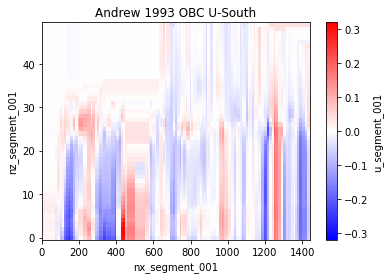

In [3]:
import matplotlib.pyplot as plt
import xarray as xr

an = xr.open_dataset("/Users/james/Documents/Github/esm_lab/obc_ic/andrew/uv_001_1993.nc")
nwa = xr.open_dataset("/Users/james/Documents/Github/esm_lab/obc_ic/nwa_shared/uv_001.nc")

an.u_segment_001.isel(ny_segment_001=0, time=0).plot(cmap='bwr')
plt.title("Andrew 1993 OBC U-South")

Text(0.5, 1.0, 'James 1993 OBC U-South')

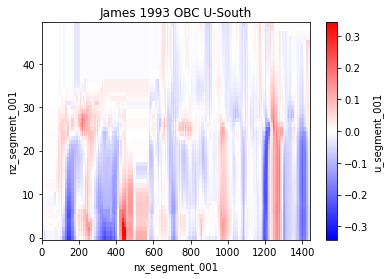

In [4]:
nwa.u_segment_001.isel(ny_segment_001=0, time=0).plot(cmap='bwr')
plt.title("James 1993 OBC U-South")

In [15]:
an.u_segment_001

<xarray.DataArray 'u_segment_001' (time: 11, nz_segment_001: 50, ny_segment_001: 1, nx_segment_001: 1441)>
[792550 values with dtype=float64]
Coordinates:
    lat_segment_001  (nx_segment_001) float64 ...
    lon_segment_001  (nx_segment_001) float64 ...
  * nx_segment_001   (nx_segment_001) int32 0 1 2 3 4 ... 1437 1438 1439 1440
  * nz_segment_001   (nz_segment_001) int32 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * time             (time) datetime64[ns] 1993-01-04T13:00:00 ... 1993-02-23...
Dimensions without coordinates: ny_segment_001

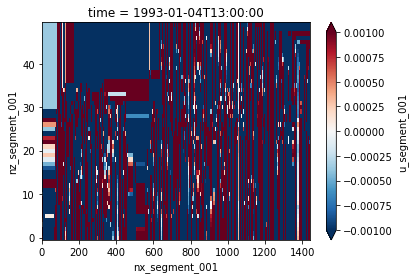

In [7]:

delta = nwa.u_segment_001.isel(ny_segment_001=0, time=0) - an.u_segment_001.isel(ny_segment_001=0, time=0)
delta.plot(vmin=-.001, vmax=.001, cmap='RdBu_r')

In [8]:
np.abs(delta).max()

<xarray.DataArray 'u_segment_001' ()>
array(0.2192127)
Coordinates:
    time     datetime64[ns] 1993-01-04T13:00:00